<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/DQN_cartpole_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Agent

In [2]:
class Agent_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(4, 32)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(32, 32)
        self.act2 = nn.ReLU()

        self.fc3  = nn.Linear(32, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        return x

In [3]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'state_next'))

class Agent_Memory():
    def __init__(self):
        self.capacity = CAPACITY #メモリの大きさ
        self.memory = []
        self.index = 0

    def sample(self, BATCH_SIZE):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        if len(self.memory) < BATCH_SIZE:
            BATCH_SIZE = len(self.memory)

        transitions = random.sample(self.memory, BATCH_SIZE) #BATCH_SIZEの分だけランダムにデータを取り出す
        BATCH = Transition(*zip(*transitions)) #State, Action, Reward, State_Nextの各要素ごとにまとめ直す

        State_BATCH      = torch.tensor( np.stack( BATCH.state ) ,dtype=torch.float)
        Action_BATCH     = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH     = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        State_Next_BATCH = np.array( BATCH.state_next ) 
        non_final_mask   = [s is not None for s in State_Next_BATCH]
        State_Next_BATCH = torch.tensor( np.stack(State_Next_BATCH[non_final_mask] ) ,dtype=torch.float)
        return State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask

    def put_memory(self, state, action, reward, state_next):
        '''transition = (state, action, reward, state_next)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, state_next)
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

In [4]:
class Agent():
    def __init__(self):
        self.Network = Agent_Network()
        self.Memory  = Agent_Memory()
        self.optim   = optim.Adam(self.Network.parameters(), lr=0.0001)

    def get_action(self, state, episode): 
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            self.Network.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                Q_values = self.Network( torch.tensor( state, dtype=torch.float ) )
                action = Q_values.argmax().detach().numpy()
        else:
            action = np.random.choice(2)   # 0,1の行動をランダムに返す
            action = np.array(action)
        return action

    def update_Network(self, BATCH_SIZE):
        if len(self.Memory.memory) < BATCH_SIZE:
            BATCH_SIZE = len(self.Memory.memory)

        # Memoryから学習用のデータをランダムに取り出す
        State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask = self.Memory.sample(BATCH_SIZE)
        Q_values = self.Network(State_BATCH).gather(1, Action_BATCH.reshape(-1,1)) # Action_BATCHのshapeは(-1)ではなく、(-1,1)の二次元である必要がある
        
        next_Q_values = torch.zeros(BATCH_SIZE) #全部0で初期化しておいて、non_finalの場所だけ計算する
        next_Q_values[non_final_mask] = self.Network(State_Next_BATCH).max(1)[0].detach()
        # max()メソッドで最大値を計算した後、[0]で数値を取り出す必要がある, detach()で勾配を消しておく    

        true_Q_values =  (Reward_BATCH + GAMMA * next_Q_values).unsqueeze(1)  #2次元配列に変換
        loss = F.smooth_l1_loss(Q_values, true_Q_values)

        self.optim.zero_grad()
        loss.backward()
        self.optim.step() 
    
    def memorize(self, state, action, reward, state_next):
        self.Memory.put_memory(state, action, reward, state_next)

# Task

In [5]:
Task_model = gym.make('CartPole-v0')

# Training Environment

In [6]:
class Environment():
    def __init__(self):
        self.Task  = Task_model
        self.Agent = Agent()
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード        
        t = 0
        state = self.Task.reset() # 各episodeの最初にTaskをリセット
        reword = 0

        while True:
            action  = self.Agent.get_action(state, episode)
            state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る
            
            if done: #倒れていたor終了した場合
                next_state = None
                if t < 195: #195ステップいないなら失敗
                    reword = -1
                else: #195ステップ以上たってたら成功
                    reword = 1
            else: #各ステップで立ってたら報酬追加
                reword = 0
            
            # 結果の記録とモデルの更新
            self.Agent.memorize(state, action, reword, state_next)
            self.Agent.update_Network(BATCH_SIZE)

            state = state_next
            t += 1

            if done:
                break
        return t
    
    def train(self):
        TIMES = []
        times = 0
        episode = 0
        while True:
            times = self.run_one_episode(episode)
            print('episode :', episode)
            print(times)
            print('='*10)
            episode += 1
            TIMES.append(times)

            if ( (len(TIMES) > 10) & (np.mean(TIMES[-10:]) >= 200) ) or (len(TIMES) > MAX_ITER):
                break
        return TIMES

episode : 0
12
episode : 1
10
episode : 2
8
episode : 3
12
episode : 4
10
episode : 5
11
episode : 6
9
episode : 7
11
episode : 8
10
episode : 9
9
episode : 10
13
episode : 11
9
episode : 12
12
episode : 13
10
episode : 14
10
episode : 15
11
episode : 16
11
episode : 17
9
episode : 18
10
episode : 19
12
episode : 20
8
episode : 21
10
episode : 22
10
episode : 23
10
episode : 24
9
episode : 25
14
episode : 26
23
episode : 27
13
episode : 28
34
episode : 29
17
episode : 30
17
episode : 31
22
episode : 32
13
episode : 33
21
episode : 34
22
episode : 35
14
episode : 36
17
episode : 37
16
episode : 38
14
episode : 39
19
episode : 40
16
episode : 41
17
episode : 42
15
episode : 43
20
episode : 44
18
episode : 45
15
episode : 46
21
episode : 47
19
episode : 48
18
episode : 49
17
episode : 50
20
episode : 51
24
episode : 52
17
episode : 53
21
episode : 54
16
episode : 55
19
episode : 56
24
episode : 57
25
episode : 58
17
episode : 59
16
episode : 60
17
episode : 61
32
episode : 62
31
episode :

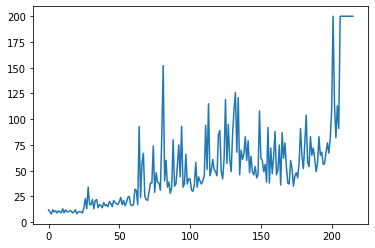

In [7]:
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
MAX_ITER = 500

AAA = Environment()
TTT = AAA.train()

X = range(len(TTT))
plt.plot(X, TTT)